In [30]:
import pandas as pd 
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import random
import seaborn as sns

In [2]:
# Import tables

# These are for Piton de la Fournaise
#eruptions = pd.read_csv("eruptions_reunion.csv")
#average_rain = pd.read_csv("average_reunion.csv")

# These are all for the Galapagos
eruptions = pd.read_csv("eruptions_galapagos.csv")
#climate_bellavista = pd.read_csv("climate_bellavista.csv")
#average_rain = climate_bellavista[['observation_date', 'precipitation']]
climate_ayora = pd.read_csv("climate_puerto-ayora.csv")
average_ayora = climate_ayora[['observation_date', 'precipitation']]

# This is the ONI water surface temperature for El Nino
oni = pd.read_csv("oni.csv")


In [3]:
# This changes the date format in the oni data into numerical values. It goes one month past and uses the first of that month to end the period.

date_converter = {'DJF': ('12', '03'), 'JFM': ('01', '04'), 'FMA': ('02', '05'), 'MAM': ('03', '06'), 'AMJ': ('04', '07'), 'MJJ': ('05', '08'), 'JJA': ('06', '09'), 'JAS': ('07', '10'), 'ASO': ('08', '11'), 'SON': ('09', '12'), 'OND': ('10', '01'), 'NDJ': ('11', '02')}

def convert_start(row):
    return str(row['YR']) + '-' + date_converter[row['SEAS']][0] + '-01' 

def convert_end(row):
    return str(row['YR']) + '-' + date_converter[row['SEAS']][1] + '-01' 

oni['Start'] = oni.apply(convert_start, axis=1)
oni['End'] = oni.apply(convert_end, axis=1)

print(oni)

    SEAS    YR  TOTAL  ANOM       Start         End
0    DJF  1950  24.72 -1.53  1950-12-01  1950-03-01
1    JFM  1950  25.17 -1.34  1950-01-01  1950-04-01
2    FMA  1950  25.75 -1.16  1950-02-01  1950-05-01
3    MAM  1950  26.12 -1.18  1950-03-01  1950-06-01
4    AMJ  1950  26.32 -1.07  1950-04-01  1950-07-01
..   ...   ...    ...   ...         ...         ...
879  MAM  2023  27.85  0.16  2023-03-01  2023-06-01
880  AMJ  2023  28.31  0.48  2023-04-01  2023-07-01
881  MJJ  2023  28.43  0.77  2023-05-01  2023-08-01
882  JJA  2023  28.36  1.07  2023-06-01  2023-09-01
883  JAS  2023  28.28  1.32  2023-07-01  2023-10-01

[884 rows x 6 columns]


.75 below appears to work best by these measures.

In [4]:
elnino = oni[oni['ANOM'] >= 0.5] # Can change the cutoff value here

# Gives a fraction of the time that El Nino is occuring.
print(len(elnino[elnino['YR'] >= 1965]) / len(oni[oni['YR'] >= 1965]))

0.2556818181818182


In [5]:
# Determines the eruption dates that occur within El Nino.

#elnino_dates = [('1951-05-01', '1952-03-01'), ('1953-01-01', '1954-03-01'), ('1957-03-01', '1958-09-01'), ('1958-10-01', '1959-05-01'), ('1963-05-01', '1964-04-01'), ('1965-05-01', '1966-06-01'), ('1968-06-01', '1970-03-01'), ('1972-04-01', '1973-05-01'), ('1976-08-01', '1977-04-01'), ('1977-08-01', '1978-03-01'), ('1979-10-01', '1980-03-01'), ('1982-04-01', '1983-08-01'), ('1986-08-01', '1988-04-01'), ('1991-05-01', '1992-08-01'), ('1993-02-01', '1993-08-01'), ('1994-08-01', '1995-05-01'), ('1997-04-01', '1998-06-01'), ('2002-05-01', '2003-04-01'), ('2004-07-01', '2005-02-01'), ('2006-08-01', '2007-03-01'), ('2009-07-01', '2010-05-01'), ('2014-10-01', '2016-06-01'), ('2018-09-01', '2019-07-01'), ('2019-10-01', '2020-03-01'), ('2023-05-01', '2023-10-01')]
eruption_dates = np.array(eruptions['Start'])
elnino_eruptions = []
for i in eruption_dates:
    for j in elnino.iterrows():
        if i >= j[1]['Start'] and i <= j[1]['End']:
            elnino_eruptions.append(i)
            break
print(elnino_eruptions)


['1991-09-25', '1968-06-11', '1972-06-04', '1995-01-25', '1977-03-23', '2015-05-25', '1982-08-28']


In [6]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [11]:
# Function for getting the accuracies when only dealing with largest amount of rain, not by season.
 
# def accs_elnino(rolling_numbers, percents, average_rain, erupt_dates):
#         predictions = []
        
#         for j in percents:
                
#                 for i in rolling_numbers:
#                         rolling_rain = average_rain.copy() 
#                         rolling_rain['roll' + str(i)] = average_rain.precipitation.rolling(i).sum()
#                         rolling_rain = rolling_rain.dropna()
#                         rainy_dates = rolling_rain.sort_values(by=['roll' + str(i)])[-(int((j/100 * len(rolling_rain)))+1):-1]

#                         rain_erup_freq = 0
#                         for l in erupt_dates:
#                                 if l in np.array(rainy_dates['observation_date']):
#                                         rain_erup_freq += 1

#                         predictions.append([i, j, rain_erup_freq / len(erupt_dates)])

#         return rainy_dates

In [12]:
# Function for getting the accuracies when considering rain by season.

# def accuracies(rolling_numbers, percents, rain_start, rain_end, average_rain, erupt_dates, start, end):
#         predictions = []
        
#         for j in percents:
                
#                 season_length = int((j * 365) / 100)
                
#                 for i in rolling_numbers:
#                         rolling_rain = average_rain.copy() 
#                         rolling_rain['roll' + str(i)] = average_rain.precipitation.rolling(i).sum()
#                         rolling_rain = rolling_rain.dropna()
#                         rainy_dates = pd.DataFrame()

#                         for k in range(end - start):
#                                 year = start + k
#                                 yearly_rain = rolling_rain[(rolling_rain['observation_date'] >= str(year) + '-' + rain_start) & (rolling_rain['observation_date'] <= str(year + 1) + '-' + rain_end)].sort_values(by=['roll' + str(i)])
#                                 rainy_dates = rainy_dates.append(yearly_rain[-(season_length+1):-1])

#                         rain_erup_freq = 0
#                         for l in erupt_dates:
#                                 if l in np.array(rainy_dates['observation_date']):
#                                         rain_erup_freq += 1

#                         predictions.append([i, j, rain_erup_freq / len(erupt_dates)])

#         return predictions


In [13]:
#Scaling the values doesn't actually do anything
# erupt_dates = eruptions['Start'][eruptions['Start'] >= '1965']
# average_ayora['regress'] = average_ayora.precipitation.rolling(90).sum()
# average_ayora['regress'] = (0.531768 * average_ayora['regress']) + 0.912098
# average_ayora = average_ayora.dropna()
# rainy_dates = pd.DataFrame()

# for k in range(59):
#     year = 1965 + k
#     yearly_rain = average_ayora[(average_ayora['observation_date'] >= str(year) + '-' + '11-01') & (average_ayora['observation_date'] <= str(year + 1) + '-' + '10-31')].sort_values(by=['regress'])
#     rainy_dates = rainy_dates.append(yearly_rain[-73:-1])

# rain_erup_freq = 0
# for l in erupt_dates:
#     if l in np.array(rainy_dates['observation_date']):
#         rain_erup_freq += 1

# print(rain_erup_freq / len(erupt_dates))

In [19]:
# # Creates the blank csv file

# csv_file_name = 'reunion_accuracies.csv'
# #Fix this so that it doesnt overwrite the header

# column_names = ['Rolling sums (days)', 'Rainy season (fraction of year)', 'Fraction of eruptions in rainy season', 'Prediction improvement']

# # Open the CSV file in write mode ('w', 'wb', or 'w+', depending on your Python version).
# with open(csv_file_name, mode='w', newline='') as csv_file:
#     # Create a DictWriter object with the column names.
#     csv_writer = csv.DictWriter(csv_file, fieldnames=column_names)

#     # Write the header (column names) to the CSV file.
#     csv_writer.writeheader()

In [5]:
# # Creates the blank csv file

# csv_file_name = 'ayora_accs_elnino.csv'
# #Fix this so that it doesnt overwrite the header

# column_names = ['Rolling sums (days)', 'Rainy season (fraction of year)', 'Fraction of eruptions in rainy season', 'Prediction improvement']

# # Open the CSV file in write mode ('w', 'wb', or 'w+', depending on your Python version).
# with open(csv_file_name, mode='w', newline='') as csv_file:
#     # Create a DictWriter object with the column names.
#     csv_writer = csv.DictWriter(csv_file, fieldnames=column_names)

#     # Write the header (column names) to the CSV file.
#     csv_writer.writeheader()

In [18]:
# # Fills the blank csv file
# erupt_dates = eruptions['Start'][eruptions['Start'] >= '1965']
# # Choose rolling number and length of rainy season
# rolling_numbers = [30, 60, 90, 120]
# percents = [5, 10, 15, 20, 25, 30]
# predictions = accs_elnino(rolling_numbers, percents, average_ayora, erupt_dates)

# # for i in predictions:
# #     with open('ayora_accs_elnino.csv', mode='a', newline='') as main:
# #         csv_writer = csv.writer(main)
# #         csv_writer.writerow([i[0], i[1]/100, round(i[2],2), round(100*((100*i[2])-i[1])/i[1],2)])

In [17]:
# # Fills the blank csv file

# # Choose rolling number and length of rainy season
# rolling_numbers = [30, 60, 90, 120]
# percents = [5, 10, 15, 20, 25, 30]

# predictions = accuracies(rolling_numbers, percents)

# for i in predictions:
#     with open('reunion_accuracies.csv', mode='a', newline='') as main:
#         csv_writer = csv.writer(main)
#         csv_writer.writerow([i[0], i[1]/100, round(i[2],2), round(100*((100*i[2])-i[1])/i[1],2)])



# # x = [i[0] for i in predictions]
# # y = [i[1] for i in predictions]

# # fig = plt.figure(figsize=(8,6))
# # ax = fig.add_subplot(111)

# # plt.scatter(x, y, c='green', s=300)

# # plt.show()

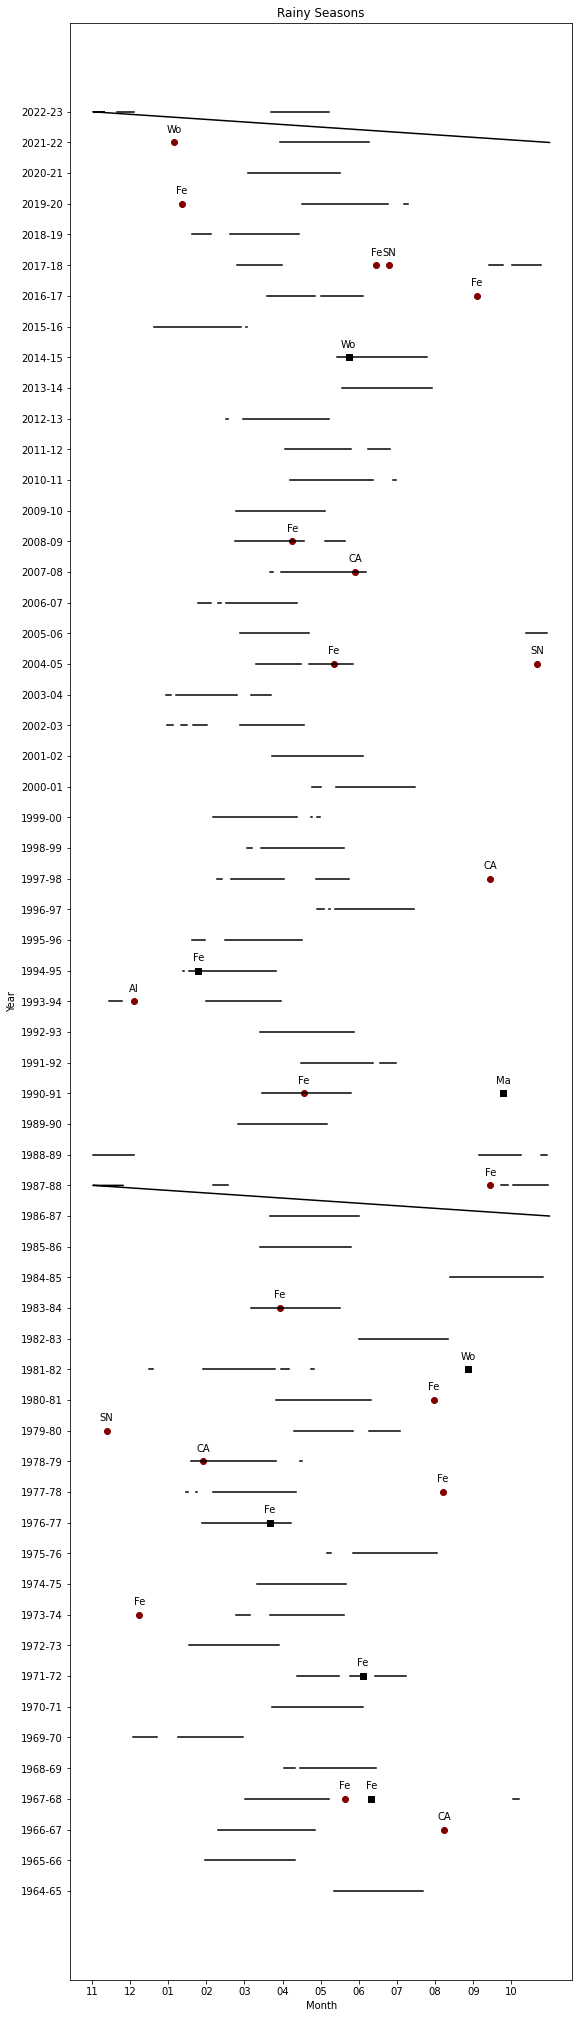

In [20]:
# Generates the rainy season plot, including black squares for El Nino eruptions
# volcanos = {'Fournaise, Piton de la': 'PF'}
volcanos = {'Fernandina': 'Fe', 'Azul, Cerro': 'CA', 'Negra, Sierra': 'SN', 'Wolf': 'Wo', 'Marchena': 'Ma', 'Alcedo': 'Al'}
erupt_dates = eruptions['Start'][eruptions['Start'] >= '1965']
rolling_rain = average_ayora.copy()
rain_start = '11-01'
rain_end = '10-31'
rolling_rain['roll90'] = average_ayora.precipitation.rolling(90).mean()
rolling_rain = rolling_rain.dropna()

plt.figure(figsize=(9,36))

decimal_erupts = np.array(erupt_dates.apply(date_to_decimal_year))
x = [((i + (2/12)) % 1) for i in decimal_erupts]
y = [(i + (2/12)) // 1 for i in decimal_erupts]
labels = list(eruptions['Volcano'][eruptions['Start'] >= '1965'])
plt.scatter(x, y, color='maroon')
for i in range(len(x)):
    plt.annotate(volcanos[labels[i]], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

decimal_nino = np.array([date_to_decimal_year(i) for i in elnino_eruptions])
x_nino = [((i + (2/12)) % 1) for i in decimal_nino]
y_nino = [(i + (2/12)) // 1 for i in decimal_nino]
plt.scatter(x_nino, y_nino, color='black', marker= 's')

all_rain = []
for k in range(59):
        year = 1964 + k
        yearly_rain = rolling_rain[(rolling_rain['observation_date'] >= str(year) + '-' + rain_start) & (rolling_rain['observation_date'] <= str(year + 1) + '-' + rain_end)].sort_values(by=['roll90'])
        rainy_season = yearly_rain[-73:].sort_values(by=['observation_date'])
        all_rain += list(rainy_season['observation_date'])
        rainy_array = np.array(rainy_season['observation_date'].apply(date_to_decimal_year))
        x = []
        y = []
        for i in range(len(rainy_array)):
                year = (rainy_array[i] + 2/12) // 1
                month_day = (rainy_array[i] + 2/12) % 1
                if len(x) == 0:
                       x.append(month_day)
                       y.append(year)
                elif rainy_array[i] - rainy_array[i-1] <= .01:
                       if i == len(rainy_array) - 1:
                                plt.plot(x, y, color='black')
                       else:
                                x.append(month_day)
                                y.append(year)   
                else:
                       plt.plot(x, y, color='black')
                       x = [month_day]
                       y = [year]

plt.yticks([1965+k for k in range(59)], [str(1964+k) + '-' + str(1965+k)[2:4] for k in range(59)])
plt.xticks([(1/12)*k for k in range(12)], ['11', '12', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10'])
plt.xlabel("Month") 
plt.ylabel("Year") 
plt.title('Rainy Seasons') 
plt.savefig("my_plot.jpg")
plt.show() 


In [39]:
# Determines fraction of the data that is considered rainy, and number of eruptions

erupt_dates = set(eruptions['Start'][eruptions['Start'] >= '1965'])
total = len(rolling_rain)
percent_rainy = 1
days = int((percent_rainy/100) * total)
rainiest = set(rolling_rain.sort_values(by=['roll90'])[-days:]['observation_date'])
all = set(all_rain)
notnew_days = rainiest.intersection(all)
unique_rainiest = {x for x in rainiest if x not in notnew_days}
percent_of_data = percent_rainy + 20 - (len(notnew_days)/total * 100)
print(percent_of_data)
print((len(erupt_dates.intersection(unique_rainiest)) + 10) / 28 * 100)

20.221955014853584
35.714285714285715


In [87]:
# Can be used to look at days added from the ONI data

# print(len(all_rain))
# uniq_all_rain = []
# for i in all_rain:
#     add = True
#     for j in elnino.iterrows():
#         if i >= j[1]['Start'] and i <= j[1]['End']:
#             add = False
#             break
#     if add == True:
#         uniq_all_rain.append(i)

# print(len(uniq_all_rain))


4307
3457


Got black dots for el nino. .32 occur during El Nino, and El Nino is only .26 of the time.

['1972-06-04', '1977-03-23', '1979-01-29', '1984-03-30', '1991-04-19', '1995-01-25', '2005-05-13', '2008-05-29', '2009-04-10', '2015-05-25']
['1972-06-04', '2015-05-25', '1982-08-28']


([<matplotlib.axis.YTick at 0x7feb140834f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

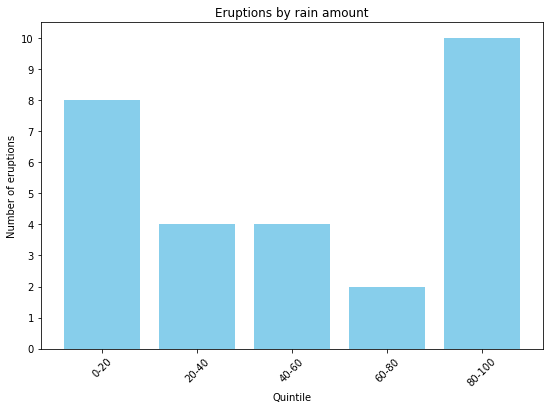

In [88]:
# Breaks up the rain by percentile

# volcanos = {'Fournaise, Piton de la': 'PF'}
volcanos = {'Fernandina': 'Fe', 'Azul, Cerro': 'CA', 'Negra, Sierra': 'SN', 'Wolf': 'Wo', 'Marchena': 'Ma', 'Alcedo': 'Al'}
erupt_dates = eruptions['Start'][eruptions['Start'] >= '1965']
rolling_rain = average_ayora.copy()
rain_start = '11-01'
rain_end = '10-31'
rolling_rain['roll90'] = average_ayora.precipitation.rolling(90).mean()
rolling_rain = rolling_rain.dropna()

plt.figure(figsize=(9,6))

categories = ['0-20', '20-40', '40-60', '60-80', '80-100']
values = [0,0,0,0,0]
top_twenty = []

for k in range(59):
        year = 1964 + k
        yearly_rain = rolling_rain[(rolling_rain['observation_date'] >= str(year) + '-' + rain_start) & (rolling_rain['observation_date'] <= str(year + 1) + '-' + rain_end)].sort_values(by=['roll90'])
        all_rain = list(yearly_rain['observation_date'])
        for l in erupt_dates:
            if l in all_rain:
                  if all_rain.index(l) // 73 == 4:
                        top_twenty.append(l)
                  values[all_rain.index(l) // 73] += 1
                  
        
print(top_twenty)
print(elnino_eruptions)
plt.bar(categories, values, color='skyblue')
plt.xlabel("Quintile")
plt.ylabel("Number of eruptions")
plt.title("Eruptions by rain amount")
plt.xticks(rotation=45) 
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])

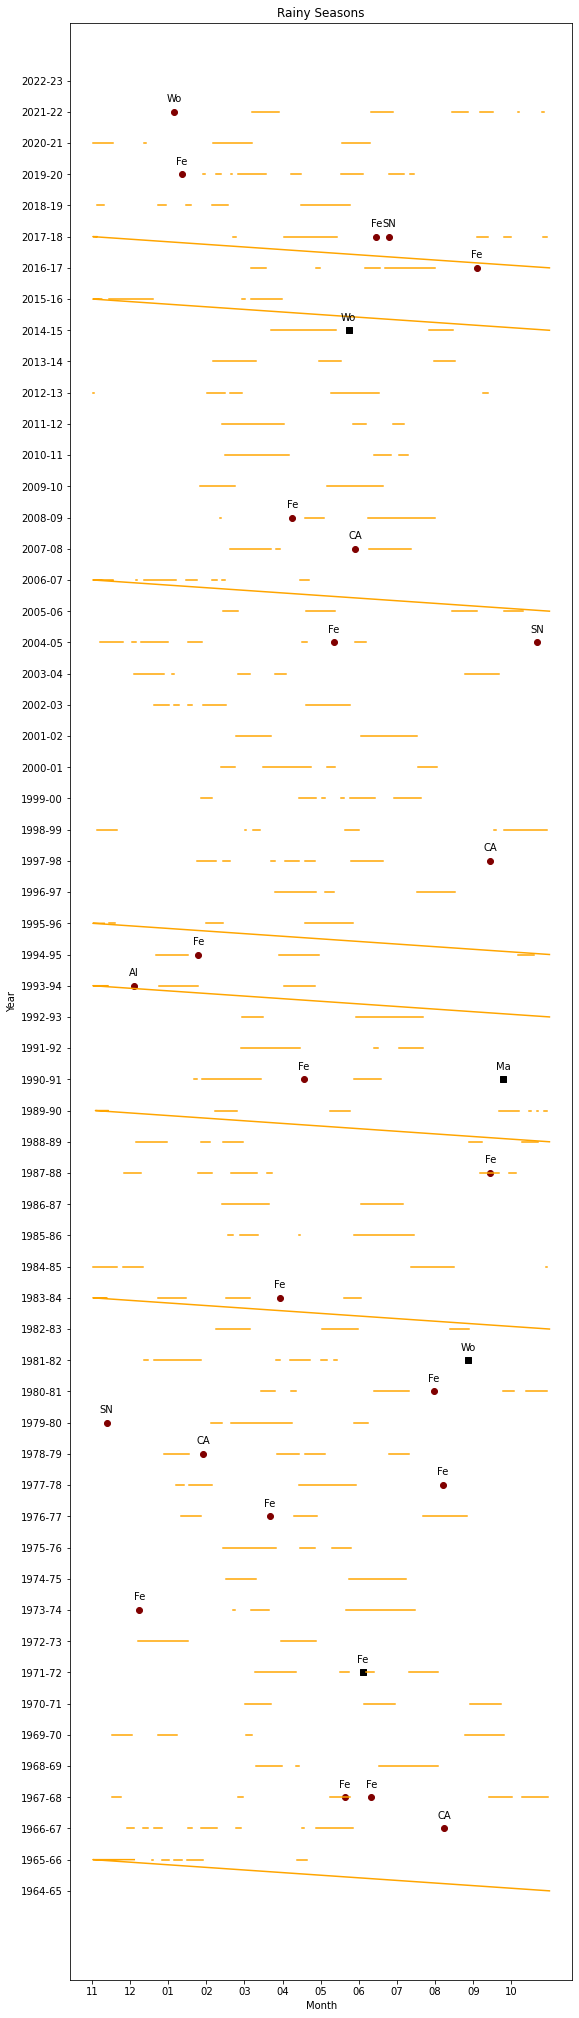

In [58]:
#60-80 percentile

# Generates the rainy season plot
# volcanos = {'Fournaise, Piton de la': 'PF'}
volcanos = {'Fernandina': 'Fe', 'Azul, Cerro': 'CA', 'Negra, Sierra': 'SN', 'Wolf': 'Wo', 'Marchena': 'Ma', 'Alcedo': 'Al'}
erupt_dates = eruptions['Start'][eruptions['Start'] >= '1965']
rolling_rain = average_ayora.copy()
rain_start = '11-01'
rain_end = '10-31'
rolling_rain['roll90'] = average_ayora.precipitation.rolling(90).mean()
rolling_rain = rolling_rain.dropna()

plt.figure(figsize=(9,36))

decimal_erupts = np.array(erupt_dates.apply(date_to_decimal_year))
x = [((i + (2/12)) % 1) for i in decimal_erupts]
y = [(i + (2/12)) // 1 for i in decimal_erupts]
labels = list(eruptions['Volcano'][eruptions['Start'] >= '1965'])
plt.scatter(x, y, color='maroon')
for i in range(len(x)):
    plt.annotate(volcanos[labels[i]], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

decimal_nino = np.array([date_to_decimal_year(i) for i in elnino_eruptions])
x_nino = [((i + (2/12)) % 1) for i in decimal_nino]
y_nino = [(i + (2/12)) // 1 for i in decimal_nino]
plt.scatter(x_nino, y_nino, color='black', marker= 's')

all_rain = []
for k in range(59):
        year = 1964 + k
        yearly_rain = rolling_rain[(rolling_rain['observation_date'] >= str(year) + '-' + rain_start) & (rolling_rain['observation_date'] <= str(year + 1) + '-' + rain_end)].sort_values(by=['roll90'])
        rainy_season = yearly_rain[219:292].sort_values(by=['observation_date'])
        all_rain += list(rainy_season['observation_date'])
        rainy_array = np.array(rainy_season['observation_date'].apply(date_to_decimal_year))
        x = []
        y = []
        for i in range(len(rainy_array)):
                year = (rainy_array[i] + 2/12) // 1
                month_day = (rainy_array[i] + 2/12) % 1
                if len(x) == 0:
                       x.append(month_day)
                       y.append(year)
                elif rainy_array[i] - rainy_array[i-1] <= .01:
                       if i == len(rainy_array) - 1:
                                plt.plot(x, y, color='orange')
                       else:
                                x.append(month_day)
                                y.append(year)   
                else:
                       plt.plot(x, y, color='orange')
                       x = [month_day]
                       y = [year]

plt.yticks([1965+k for k in range(59)], [str(1964+k) + '-' + str(1965+k)[2:4] for k in range(59)])
plt.xticks([(1/12)*k for k in range(12)], ['11', '12', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10'])
plt.xlabel("Month") 
plt.ylabel("Year") 
plt.title('Rainy Seasons') 
plt.savefig("my_plot2.jpg")
plt.show() 
